In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tcvae import tsms
from tcvae import dataset, model, localconfig, utils
from IPython.display import Audio
import soundfile as sf

plt.style.use("dark_background")

2021-07-09 07:40:49.510 | INFO     | tcvae.train:<module>:18 - 1


## Setup Config, Load Test Set and Model

In [2]:
conf = localconfig.LocalConfig()
conf.load_config_from_file("checkpoints/Default_decoder_only.json")
conf.dataset_dir = "complete_dataset"

_, _, test = dataset.get_dataset(conf)
test_iterable = iter(test)

vae = model.create_vae(conf) if conf.use_encoder else model.create_decoder(conf)
vae.load_weights("checkpoints/21_decoder_only_2.03.h5")

if conf.use_encoder:
    encoder = model.create_encoder(conf)
    encoder_weights = vae.layers[1].get_weights()
    encoder.set_weights(encoder_weights)

    z, p, i, v = model.decoder_inputs(conf)

    decoder_output = vae.layers[-1]([z, p, v, i])
    decoder = tf.keras.Model([z, p, i, v], decoder_output)


In [18]:
z_mean, z_log_variance = None, None


def reconstruct_audio(freq, mag):
    phase = tsms.core.generate_phase(
        freq, conf.sample_rate,
        conf.frame_size
    )
    return tsms.core.harmonic_synthesis(
        h_freq=freq, h_mag=mag, h_phase=phase,
        sample_rate=conf.sample_rate,
        frame_step=conf.frame_size
    )


def get_prediction(batch, **kwargs):
    global z_mean, z_log_variance

    h = batch["h"]
    note_number = batch["note_number"]
    velocity= batch["velocity"]
    instrument_id = batch["instrument_id"]
    using_z = False

    print("Original id", np.argmax(instrument_id))

    if kwargs.get("instrument_id") is not None:
        desired_id = kwargs.get("instrument_id")
        instrument_id = np.zeros((1, 74))
        instrument_id[0, desired_id] = 1.

    if kwargs.get("note_number") is not None:
        desired_pitch = kwargs.get("note_number")
        note_number = np.zeros((1, 49))
        note_number[0, desired_pitch] = 1.

    if kwargs.get("velocity") is not None:
        desired_velocity = kwargs.get("velocity")
        velocity = np.zeros((1, 5))
        velocity[0, desired_velocity] = 1.

    if kwargs.get("z") is not None:
        desired_z = kwargs.get("z")
        using_z = True

    if conf.use_encoder:
        z, z_mean, z_log_variance = encoder.predict(h)
        inputs = [z, note_number, instrument_id, velocity]
    else:
        inputs = [note_number, velocity, instrument_id]

    if using_z:
        inputs[0] = desired_z
        print("Using custom z")

    if conf.use_encoder:
        pred = decoder.predict(inputs)
    else:
        pred = vae.predict(inputs)
    pitch = 40 + tf.argmax(note_number[0])
    f0_from_note = tsms.core.midi_to_hz(
        tf.cast(pitch, dtype=tf.float32)
    )

    harmonics = tsms.core.get_number_harmonics(
        f0_from_note, conf.sample_rate
    )

    h_freq_pred = pred[:, :1001, :harmonics, 0]
    h_mag_pred = pred[:, :1001, :harmonics, 1]

    h_freq_gt = h[:, :1001, :harmonics, 0]
    h_mag_gt = h[:, :1001, :harmonics, 1]

    h_freq_gt = utils.denormalize_h_freq(h_freq_gt, pitch)
    h_freq_pred = utils.denormalize_h_freq(h_freq_pred, pitch)
    h_mag_gt = utils.denormalize_h_mag(h_mag_gt)
    h_mag_pred = utils.denormalize_h_mag(h_mag_pred)

    return (h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt)

## Get Predictions

In [19]:
def save_predictions(batch, prefix, display=False,
                     instrument_id=None,
                     note_number=None,
                     velocity=None,
                     z=None):
    prefix = os.path.join("predictions", prefix)

    if not os.path.isdir(prefix):
        os.mkdir(prefix)

    (h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt) = get_prediction(
        batch, instrument_id=instrument_id, velocity=velocity,
        note_number=note_number, z=z
    )

    audio_pred = reconstruct_audio(
        h_freq_pred, h_mag_pred
    )
    audio_gt = reconstruct_audio(
        h_freq_gt, h_mag_gt
    )

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(h_freq_gt[0])

    plt.subplot(2, 1, 2)
    plt.plot(h_freq_pred[0])

    if display:
        plt.show()
    else:
        plt.savefig(os.path.join(prefix, "freq.png"))
    plt.close()

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(h_mag_gt[0])

    plt.subplot(2, 1, 2)
    plt.plot(h_mag_pred[0])

    if display:
        plt.show()
    else:
        plt.savefig(os.path.join(prefix, "mag.png"))
    plt.close()

    if not display:
        gt_path = os.path.join(prefix, "gt_audio.wav")
        pred_path = os.path.join(prefix, "pred_audio.wav")

        sf.write(gt_path, audio_gt.numpy()[0], samplerate=conf.sample_rate,)
        sf.write(pred_path, audio_pred.numpy()[0], samplerate=conf.sample_rate)
        return
    return audio_gt, audio_pred


def get_sample():
    sample = model.sample_from_latent_space([z_mean, z_log_variance])
    print(np.mean(sample), np.min(sample), np.max(sample))
    return sample

In [45]:
# for i in range(0, 20):
#     batch = next(test_iterable)
#     save_predictions(batch, str(i))

Original id 43


Original id 53


Original id 19


Original id 42


Original id 21
Original id 8


Original id 57


Original id 57


Original id 14
Original id 15
Original id 36
Original id 19
Original id 52
Original id 70
Original id 43


Original id 36


Original id 41
Original id 63


Original id 71
Original id 61


In [41]:
batch = next(test_iterable)

Original id 69


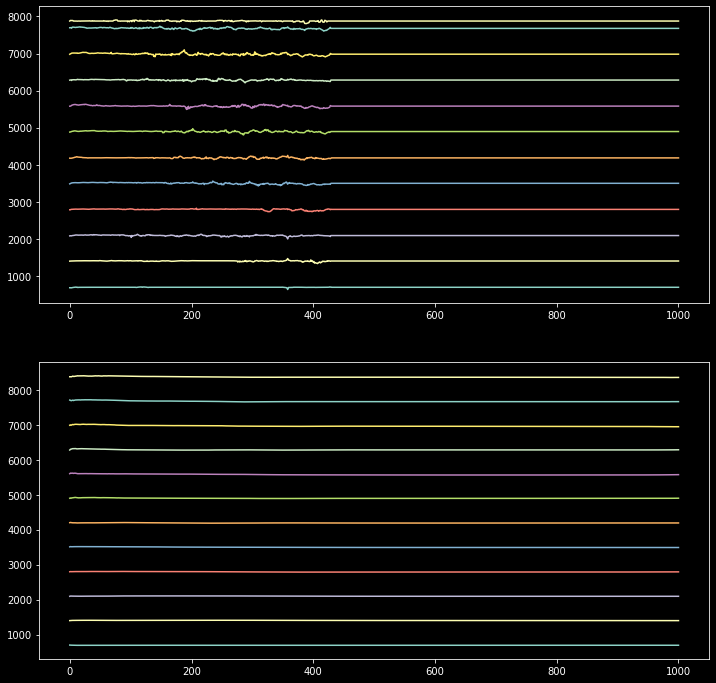

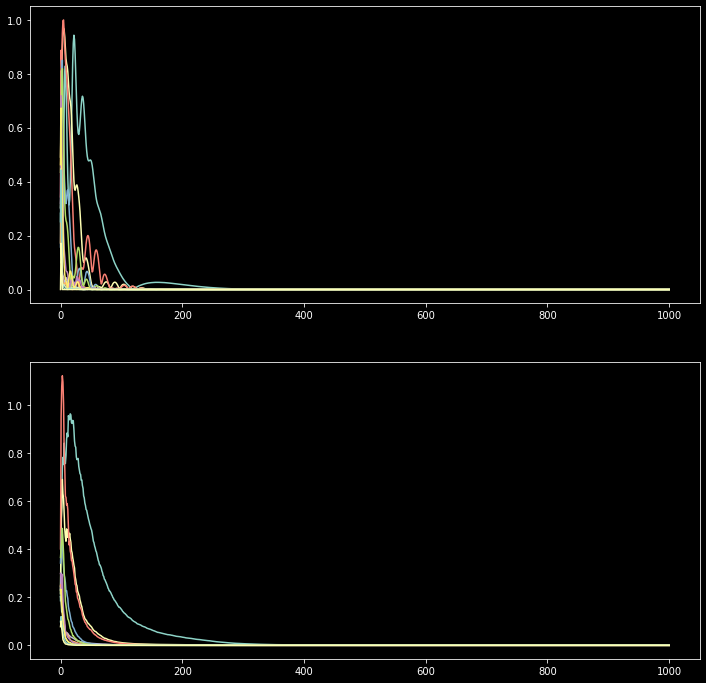

In [42]:
gt, pred = save_predictions(
    batch, "", display=True,
    # z=get_sample(),
    # instrument_id=9,
    # note_number=10
)

In [43]:
Audio(gt, rate=conf.sample_rate)

In [44]:
Audio(pred, rate=conf.sample_rate)